In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.3 MB/s eta 0:00:00


# data

In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

In [4]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

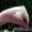

In [5]:
train_ds[0]['img']

In [6]:
train_ds[0]['label']

2

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
id2label[train_ds[0]['label']]

'bird'

# Preprocessing the data

In [9]:
from transformers import ViTFeatureExtractor, BeitImageProcessor

feature_extractor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

In [10]:
feature_extractor.size

{'height': 224, 'width': 224}

In [11]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples


In [12]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [13]:
train_ds[0]['pixel_values'].size(dim=1)

224

In [14]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FBF15722520>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FBF15722550>],
 'label': [2, 3],
 'pixel_values': [tensor([[[-0.9373, -0.9373, -0.9373,  ..., -0.9373, -0.9373, -0.9373],
           [-0.9373, -0.9373, -0.9373,  ..., -0.9373, -0.9373, -0.9373],
           [-0.9373, -0.9373, -0.9373,  ..., -0.9373, -0.9373, -0.9373],
           ...,
           [-0.6627, -0.6627, -0.6627,  ..., -0.9059, -0.9059, -0.9059],
           [-0.6627, -0.6627, -0.6627,  ..., -0.9059, -0.9059, -0.9059],
           [-0.6627, -0.6627, -0.6627,  ..., -0.9059, -0.9059, -0.9059]],
  
          [[-0.8431, -0.8431, -0.8431,  ..., -0.8667, -0.8667, -0.8667],
           [-0.8431, -0.8431, -0.8431,  ..., -0.8667, -0.8667, -0.8667],
           [-0.8431, -0.8431, -0.8431,  ..., -0.8667, -0.8667, -0.8667],
           ...,
           [-0.6392, -0.6392, -0.6392,  ..., -0.9216, -0.9216, -0.9216],
           [-0.6392, -0.6392, 

pytorch dataloader

In [15]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# define the model

In [17]:
from transformers import ViTForImageClassification, BeitForImageClassification

model =BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    report_to="wandb",
    remove_unused_columns=False,
)

PyTorch: setting up devices


In [19]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-19-73d77e7e10a9>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


**just training the mlp head**

In [20]:
i = 0
for child in model.children():
  i =i + 1
  if i < 2:
    for param in child.parameters():
        param.requires_grad = False

In [33]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [34]:
wandb.init(project="test-project", entity="arman_forouz")

wandb: Currently logged in as: armanforouz0 (arman_forouz). Use `wandb login --relogin` to force relogin


In [35]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [49]:
!pip install torchview

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


train

In [37]:
%%wandb
trainer.train()

***** Running training *****
  Num examples = 4500
  Num Epochs = 10
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 4500
  Number of trainable parameters = 7690


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.578304,0.588000
2,2.001000,1.010285,0.800000
3,1.349800,0.717848,0.882000
4,1.038100,0.559435,0.910000
5,0.865100,0.467424,0.930000
6,0.792800,0.413084,0.942000
7,0.733900,0.377704,0.948000
8,0.705400,0.358354,0.950000
9,0.708100,0.347907,0.952000
10,0.699200,0.345098,0.952000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-450
Configuration saved in test-cifar-10/checkpoint-450/config.json
Model weights saved in test-cifar-10/checkpoint-450/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-450/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-900
Configuration saved in test-cifar-10/checkpoint-900/config.json
Model weights saved in test-cifar-10/checkpoint-900/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-900/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 500
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1350
Configuration saved in test-cifar-10/checkpoint-1350/config.json
Model weights saved in test-cifar-10/checkpoint-1350/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-1350/preproc

TrainOutput(global_step=4500, training_loss=0.9881597900390625, metrics={'train_runtime': 694.4635, 'train_samples_per_second': 64.798, 'train_steps_per_second': 6.48, 'total_flos': 3.5378002864266854e+18, 'train_loss': 0.9881597900390625, 'epoch': 10.0})

# Evaluation

In [38]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2000
  Batch size = 4


In [39]:
print(outputs.metrics)

{'test_loss': 0.3270889222621918, 'test_accuracy': 0.946, 'test_runtime': 29.0827, 'test_samples_per_second': 68.769, 'test_steps_per_second': 17.192}


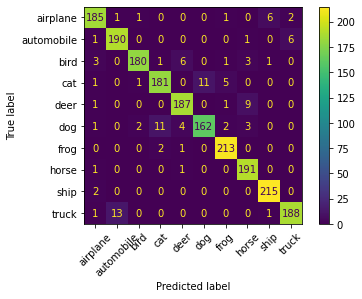

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)